In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

#! make plotting utils as submodule
from texplot import configure_mpl

configure_mpl()

## Read npz archives

In [2]:
# read npz file
exp_data = np.load('SiO2_EXP_highres_3.npz')
step_data = np.load('SiO2_STEP_highres_2.npz')

xmax = 27 # micron
tmax = 240 # femtoseconds

In [3]:
exp_data['Electric_Field_Ey'].shape

(4801, 4000)

## Some helpful functions

In [38]:
def denoise(arr: np.ndarray, cutoff: float, order: int = 4):

    import scipy.signal as signal

    B, A = signal.butter(order, cutoff, btype='low', analog=False)
    smooth_data = signal.filtfilt(B, A, arr)

    return smooth_data

# .............................. #

def denoise_efield(
        
        data: np.ndarray, 
        cutoff: float = 0.5, 
        order: int = 4, 
        slice1 = slice(1000, 2200),
        slice2 = slice(2200, 3400), 
        x: int = 800 * 2

    ):

    efield = data['Electric_Field_Ey'].copy()
    slice1 = efield[slice1, x].copy()
    slice2 = efield[slice2, x].copy()

    ts = tmax * 1e-15 / efield.shape[0]
    fs = 1 / ts

    tline = np.arange(0, efield.shape[0] * ts, ts)

    # quite good signal, so can apply always
    slice1 = denoise(slice1, cutoff=cutoff, order=order)

    n = len(slice1)
    k = np.arange(n)
    T = n / fs
    frq = k / T
    frq = frq[range(n // 2)]

    slice1fft = np.fft.fft(slice1) / n
    slice1fft = slice1fft[range(n // 2)]
    slice2fft = np.fft.fft(slice2) / n
    slice2fft = slice2fft[range(n // 2)]

    return slice1fft, slice2fft, slice1, slice2, tline, frq

## Get necessary data

In [105]:
1 / 4 * 27

6.75

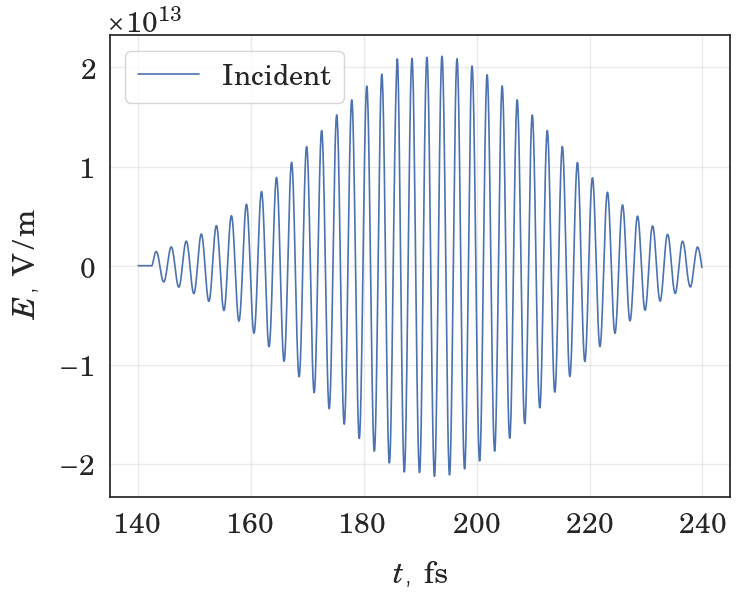

In [103]:
slice_inc_pulse = slice(400, 2400)
slice_ref_pulse = slice(2800, 4800)
x_coord = 1000

inc_freq, ref_freq, inc_time, ref_time, timeline, freqs = denoise_efield(
                                                                exp_data,
                                                                slice1=slice_inc_pulse,
                                                                slice2=slice_ref_pulse,
                                                                x=x_coord,
                                                                cutoff=0.2,
                                                                order=2
                                                            )

_, ref_freq_step, _, ref_time_step, _, _ = denoise_efield(
                                                                step_data,
                                                                slice1=slice_inc_pulse,
                                                                slice2=slice_ref_pulse,
                                                                x=x_coord,
                                                                cutoff=0.2,
                                                                order=2
                                                            )

# .............................. #

def plot_time_dep(
        
        tm: np.ndarray,
        ampl: np.ndarray, 
        xlabel: str = r'$t$, $\rm{fs}$',
        ylabel: str = r'$E$, $\rm{V}\:/\:{m}$',
        label: str = None,
        **kwargs

    ):

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(tm, ampl, label=label, **kwargs)
    ax.set_xlabel(xlabel, labelpad=15)
    ax.set_ylabel(ylabel, labelpad=15)

    if label:
        ax.legend()

    return fig, ax

# .............................. #

def plot_freq_dep(
        
        freq: np.ndarray,
        ampl: np.ndarray, 
        xlabel: str = r'$\omega\:/\:\omega_0$',
        ylabel: str = r'$\rm{Amplitude}$, $\rm{a.u.}$',
        basefreq: float = 1e12,
        normvalue: float = 1,
        label: str = None,
        **kwargs

    ):


    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(freq / basefreq, abs(ampl) / normvalue, label=label, **kwargs)
    ax.set_xlabel(xlabel, labelpad=15)
    ax.set_ylabel(ylabel, labelpad=15)
    ax.set_yscale('log')
    ax.xaxis.set_major_locator(ticker.LinearLocator(11))

    if label:
        ax.legend()

    return fig, ax


f, a = plot_time_dep(
            timeline[slice_ref_pulse] * 1e15, 
            inc_time, 
            linewidth=1.2, 
            # color='purple', 
            label=r'$\rm{Incident}$'
        )
# f.savefig('../tex/img/exp_data/inc_pulse.png', dpi=300, bbox_inches='tight')

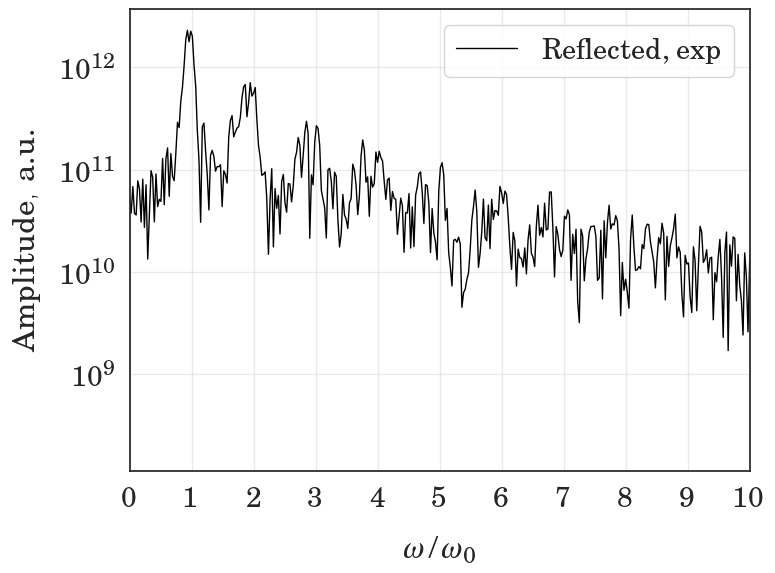

In [98]:
basefreq = (3e8 / 8e-7)

f, a = plot_freq_dep(
            freqs, 
            ref_freq, 
            basefreq=basefreq, 
            linewidth=1., 
            color='black',
            label=r'$\rm{Reflected},\:\rm{exp}$'
        )
a.set_xlim(0, 10)
# f.savefig('../tex/img/exp_data/ref_pulse_freq.png', dpi=300, bbox_inches='tight')

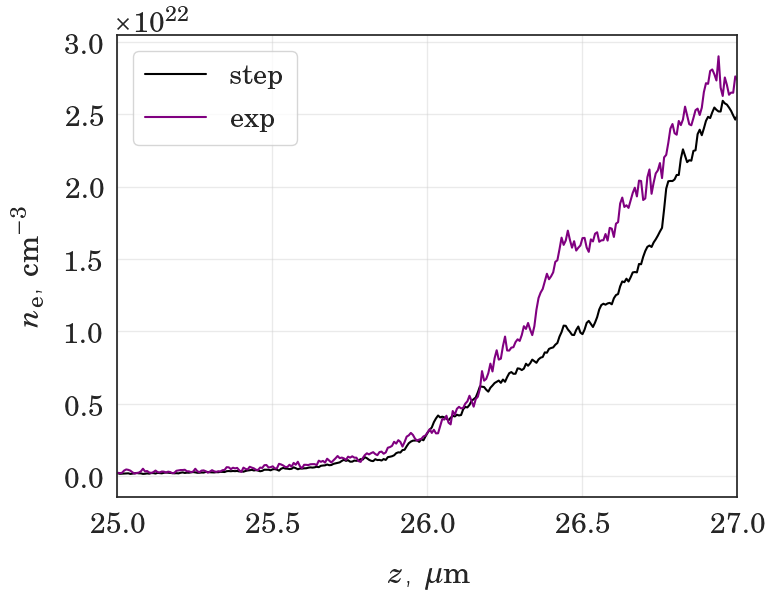

In [123]:
# .............................. #

def plot_density_timepoint(
        
        denses: list, 
        xlabel: str = r'$z$, $\rm{\mu m}$',
        ylabel: str = r'$n_{\rm{e}}$, $\rm{cm}^{-3}$',
        timepoint: int = 0,
        xlim: tuple = (25, 27),
        xmax: float = 27,
        labels: list = [r'$\rm{step}$', r'$\rm{exp}$'],
        colors: list = ['black', 'purple'],
        **kwargs

    ):


    fig, ax = plt.subplots(figsize=(8, 6))

    for dens, label, color in zip(denses, labels, colors):
        coord = np.linspace(0, xmax, dens.shape[1], endpoint=True)
        ax.plot(coord, dens[timepoint] / 1e6, label=label, color=color, **kwargs)

    ax.set_xlabel(xlabel, labelpad=15)
    ax.set_ylabel(ylabel, labelpad=15)
    ax.set_xlim(xlim)
    ax.legend()

    return fig, ax

# .............................. #

ne_exp = exp_data['Derived_Number_Density_electron'].copy() / np.cos(47 / 180 * np.pi)
ne_step = step_data['Derived_Number_Density_electron'].copy() / np.cos(47 / 180 * np.pi)

timepoint = 220
idx = int(timepoint * ne_exp.shape[0] / 240)

denses = [ne_step, ne_exp]

f, a = plot_density_timepoint(denses, timepoint=idx)
f.savefig(f'../tex/img/exp_step_data/ne_{timepoint}fs.png', dpi=300, bbox_inches='tight')

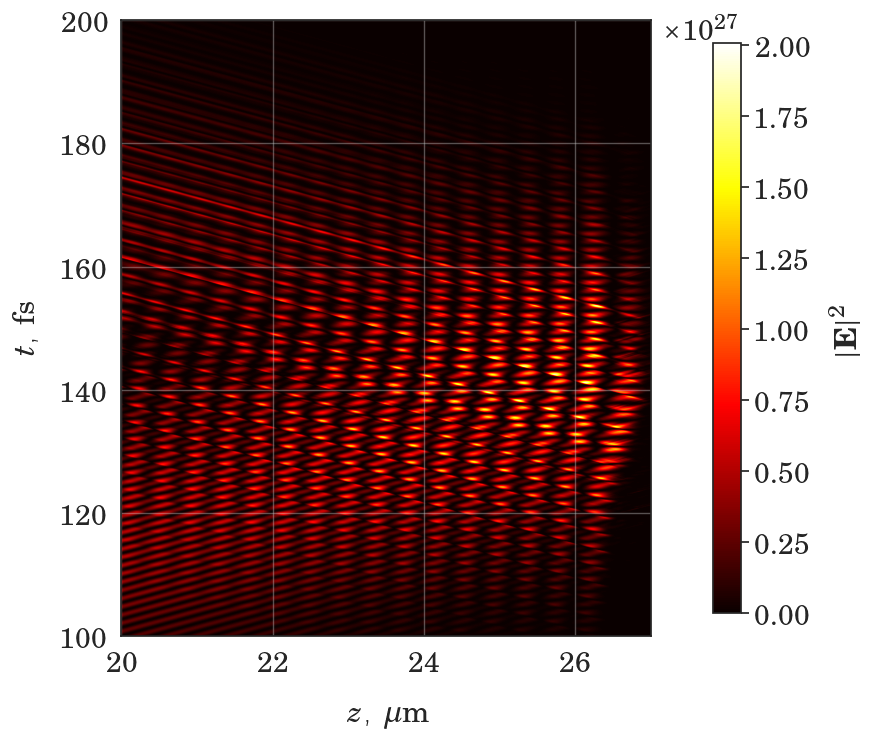

In [130]:
def plot_efield_2d(
        
        data: np.ndarray
            
    ):

    fig, ax = plt.subplots(figsize=(8, 8))

    ey = ax.imshow(data['Derived_Number_Density_electron'], aspect='auto', origin='lower', extent=[0, 27, 0, 240], cmap='hot')
    ax.set_xlabel(r'$z$, $\rm{\mu m}$', labelpad=15)
    ax.set_ylabel(r'$t$, $\rm{fs}$', labelpad=15)

    cbar = plt.colorbar(ey, fraction=0.046, pad=0.1)
    cbar.set_label(r'$|\mathbf{E}|^2$', labelpad=15)

    return fig, ax

f, a = plot_efield_2d(exp_data)
a.set_xlim(20, 27)
a.set_ylim(100, 200)
# f.savefig('../tex/img/exp_data/efield_2d_zone.png', dpi=300, bbox_inches='tight')

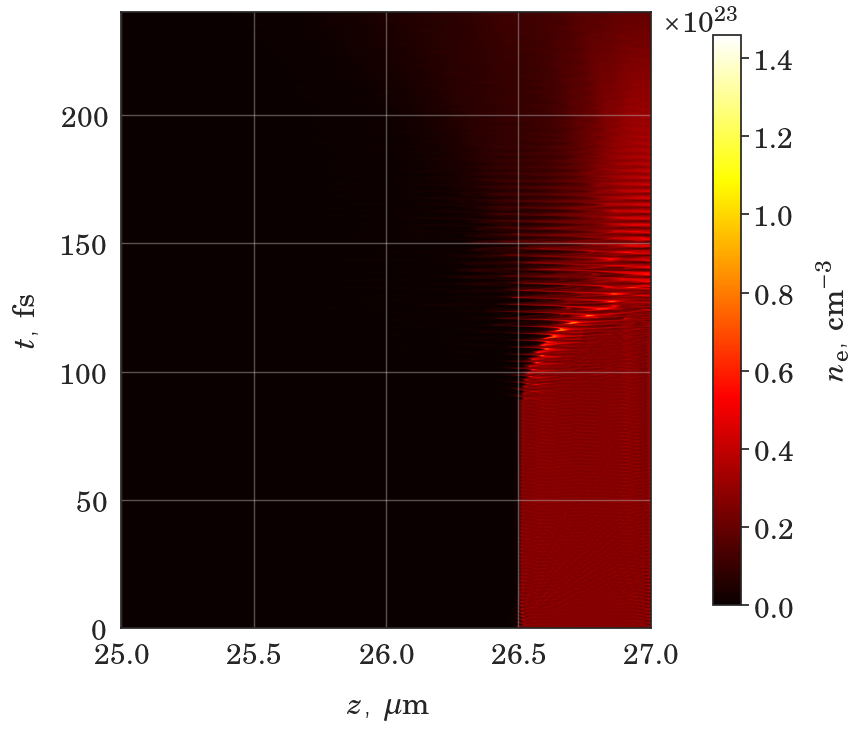

In [156]:
def plot_ne_2d(
        
        data: np.ndarray
            
    ):

    fig, ax = plt.subplots(figsize=(8, 8))

    ey = ax.imshow(data['Derived_Number_Density_electron'] / np.cos(47 / 180 * np.pi) / 1e6, aspect='auto', origin='lower', extent=[0, 27, 0, 240], cmap='hot')
    ax.set_xlabel(r'$z$, $\rm{\mu m}$', labelpad=15)
    ax.set_ylabel(r'$t$, $\rm{fs}$', labelpad=15)

    cbar = plt.colorbar(ey, fraction=0.046, pad=0.1)
    cbar.set_label(r'$n_{\rm{e}}$, $\rm{cm}^{-3}$', labelpad=15)

    return fig, ax

f, a = plot_ne_2d(step_data)
a.set_xlim(25, 27)
# a.set_ylim(100, 200)

f.savefig('../tex/img/step_data/ne_2d.png', dpi=300, bbox_inches='tight')

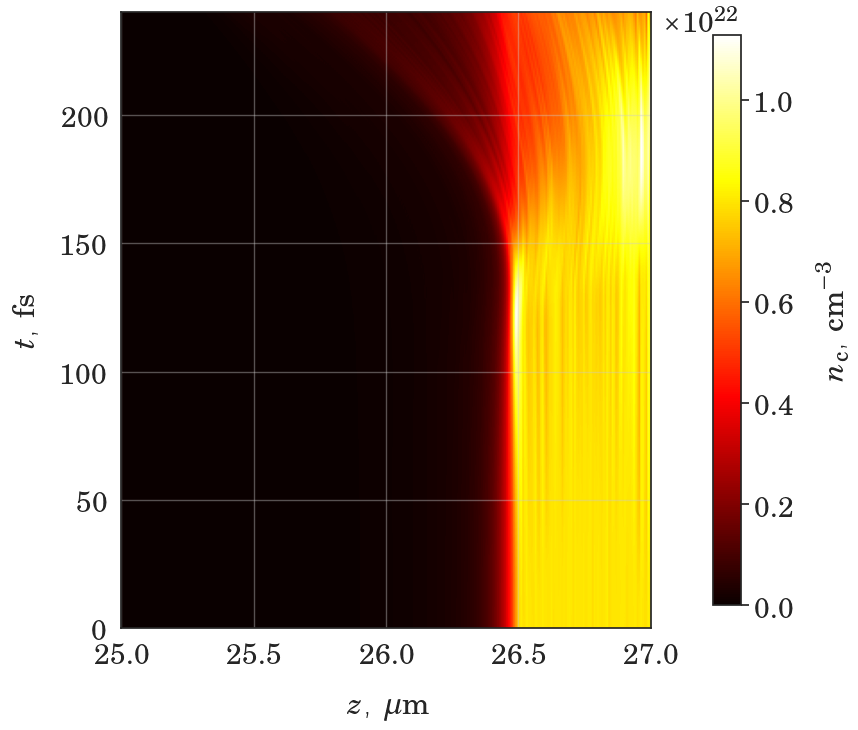

In [152]:
def plot_ni_2d(
        
        data: np.ndarray
            
    ):

    fig, ax = plt.subplots(figsize=(8, 8))

    ey = ax.imshow(data['Derived_Number_Density_silicon'] / np.cos(47 / 180 * np.pi) / 1e6, aspect='auto', origin='lower', extent=[0, 27, 0, 240], cmap='hot')
    ax.set_xlabel(r'$z$, $\rm{\mu m}$', labelpad=15)
    ax.set_ylabel(r'$t$, $\rm{fs}$', labelpad=15)

    cbar = plt.colorbar(ey, fraction=0.046, pad=0.1)
    cbar.set_label(r'$n_{\rm{c}}$, $\rm{cm}^{-3}$', labelpad=15)

    return fig, ax

f, a = plot_ni_2d(exp_data)
a.set_xlim(25, 27)
# a.set_ylim(100, 200)

f.savefig('../tex/img/exp_data/ni_2d.png', dpi=300, bbox_inches='tight')